In [2]:
import os
os.chdir("..")

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные значения метрик на `val` в формате `pred_val_template.csv`;
- html страницу с предсказанием модели для всех картинок из `real_test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез, анализ данных и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

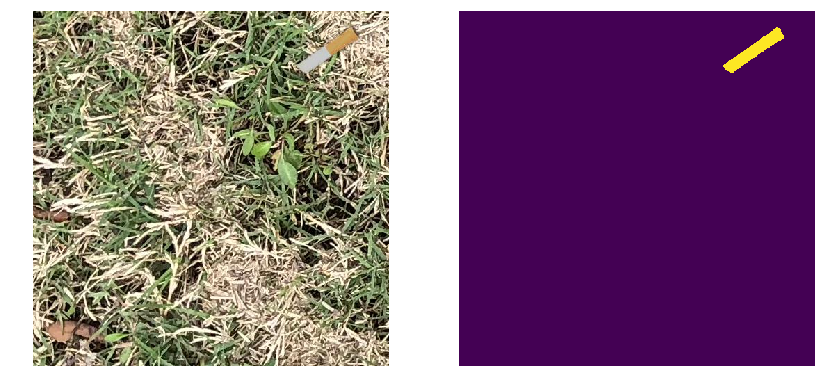

In [3]:
path = "data/cig_butts/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [4]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.012625862654146388

In [13]:
np.unique(mask)

array([  0, 255], dtype=uint8)

Можно для последовательности масок вычислить среднее значение метрики:

In [27]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.4997469613904002

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [5]:
rle_mask = encode_rle(mask)
rle_mask

'12746 1 13257 3 13767 7 14278 9 14789 11 15300 12 15810 14 16321 16 16832 17 17343 19 17853 22 18364 23 18874 26 19383 30 19894 31 20405 31 20916 32 21427 32 21938 31 22449 31 22959 31 23470 30 23980 31 24491 30 25001 31 25512 30 26023 29 26533 30 27044 29 27554 30 28065 29 28575 29 29086 29 29596 29 30107 29 30617 30 31128 29 31639 29 32149 29 32660 29 33170 29 33681 29 34191 30 34702 29 35212 30 35723 29 36233 30 36744 29 37254 30 37765 30 38276 29 38786 30 39297 29 39807 30 40318 29 40828 30 41339 30 41852 27 42366 24 42879 21 43391 20 43904 17 44417 15 44931 12 45445 8 45959 5 46473 1'

Теперь восстановим маску:

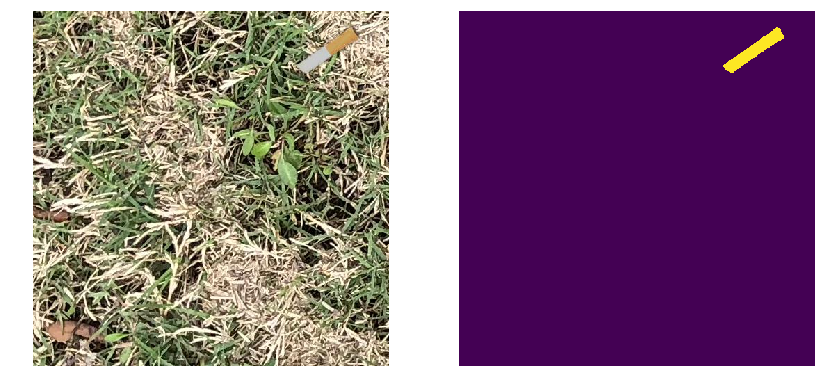

In [6]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [9]:
pred = pd.read_csv("data/pred_val_template.csv")
pred.head()

,img_id,rle_mask
0,0,171654 1 172158 1 172164 5 172670 3 172674 12 ...
1,1,171654 1 172158 1 172164 5 172670 3 172674 12 ...
2,2,171654 1 172158 1 172164 5 172670 3 172674 12 ...
3,3,171654 1 172158 1 172164 5 172670 3 172674 12 ...
4,4,171654 1 172158 1 172164 5 172670 3 172674 12 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [35]:
val_annotations = json.load(open(f"data/cig_butts/val/coco_annotations.json", "r"))
paths_to_imgs = sorted(glob("data/cig_butts/val/images/*"))
img_ids = [int(path.split("/")[-1].split(".")[0]) for path in paths_to_imgs]
pred_masks = [get_mask(img_id, val_annotations) for img_id in sorted(img_ids)]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.